# Enviorment setup

## Libraries

In [28]:
# Import external libraries
import duckdb as db
import mlflow
import numpy as np
import optuna
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import sys
import xgboost as xgb

from importlib import reload
from pathlib import Path
from pprint import pprint
from sklearn.calibration import CalibratedClassifierCV
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import roc_curve, auc, average_precision_score, precision_score, recall_score, f1_score, precision_recall_curve, auc, log_loss
from sklearn.model_selection import train_test_split, StratifiedKFold

In [2]:
# Project path
project_path = Path('.').resolve().parent

# Include in path
sys.path.append(str(project_path))

In [3]:
# Import auxiliary functions
from src import auxiliary as aux
from src import model
from src import plot

## Parameters

In [4]:
# Import parameters
prm = aux.load_parameters()
pprint(prm, depth=2)

{'models': {'features': [...], 'split': {...}, 'target': [...]},
 'plotly': {'colors': {...},
            'histogram': {...},
            'renderer': 'vscode+pdf+png+jpeg',
            'theme': 'plotly_white',
            'transparency': 0.65},
 'purchase-database': {'columns': {...}, 'quantiles': {...}}}


## Plotly

In [5]:
# Set Plotly theme and render
pio.templates.default = prm['plotly']['theme']
pio.renderers.default = prm['plotly']['renderer']

## Options

In [6]:
# Ignore warnings from pandas downcasting
pd.set_option('future.no_silent_downcasting', True)

# Model development

## Data import

In [7]:
# If train and test data exists, read them, otherwise read eda data and split it
X_train_path = project_path.joinpath('data', 'processed', 'X_train.csv')
X_calib_path = project_path.joinpath('data', 'processed', 'X_calib.csv')
X_test_path = project_path.joinpath('data', 'processed', 'X_test.csv')
y_train_path = project_path.joinpath('data', 'processed', 'y_train.csv')
y_calib_path = project_path.joinpath('data', 'processed', 'y_calib.csv')
y_test_path = project_path.joinpath('data', 'processed', 'y_test.csv')

current_model_train_scores_path = project_path.joinpath('data', 'processed', 'current_model_train_scores.csv')
current_model_calib_scores_path = project_path.joinpath('data', 'processed', 'current_model_calib_scores.csv')
current_model_test_scores_path = project_path.joinpath('data', 'processed', 'current_model_test_scores.csv')

purchases_eda_path = project_path.joinpath('data', 'processed', 'purchases-eda.csv')

files_exists = (
    X_train_path.exists()
    and
    X_calib_path.exists()
    and
    X_test_path.exists()
    and
    y_train_path.exists()
    and
    y_calib_path.exists()
    and
    y_test_path.exists()
    and
    current_model_train_scores_path.exists()
    and
    current_model_calib_scores_path.exists()
    and
    current_model_test_scores_path.exists()
)

if files_exists:
    X_train = pd.read_csv(X_train_path, dtype={'country': 'category'}, low_memory=False)
    X_calib = pd.read_csv(X_calib_path, dtype={'country': 'category'}, low_memory=False)
    X_test  = pd.read_csv(X_test_path, dtype={'country': 'category'}, low_memory=False)
    y_train = pd.read_csv(y_train_path, low_memory=False)
    y_calib = pd.read_csv(y_calib_path, low_memory=False)
    y_test  = pd.read_csv(y_test_path, low_memory=False)

    current_model_train_scores = pd.read_csv(current_model_train_scores_path, low_memory=False)
    current_model_calib_scores = pd.read_csv(current_model_calib_scores_path, low_memory=False)
    current_model_test_scores  = pd.read_csv(current_model_test_scores_path, low_memory=False)
else:
    purchases = pd.read_csv(
        purchases_eda_path,
        dtype={'country': 'category'},
        low_memory=False
    )

    # Divide fraud_score_model by 100
    purchases['fraud_score_model'] = purchases['fraud_score_model'] / 100

    # Split data in train, calibration and test
    X_train, X_calib_test, y_train, y_calib_test = train_test_split(
        purchases[[*prm['models']['features'], 'fraud_score_model']],
        purchases[prm['models']['target']],
        train_size=prm['models']['split']['train'],
        stratify=purchases[prm['models']['target']],
    )

    X_calib, X_test, y_calib, y_test = train_test_split(
        X_calib_test,
        y_calib_test,
        test_size=prm['models']['split']['test'] / (1 - prm['models']['split']['train']),
        stratify=y_calib_test,
    )

    current_model_train_scores = pd.concat([X_train[['purchase_value', 'fraud_score_model']], y_train], axis=1)
    current_model_calib_scores = pd.concat([X_calib[['purchase_value', 'fraud_score_model']], y_calib], axis=1)
    current_model_test_scores = pd.concat([X_test[['purchase_value', 'fraud_score_model']], y_test], axis=1)

    current_model_train_scores.to_csv(current_model_train_scores_path, index=False)
    current_model_calib_scores.to_csv(current_model_calib_scores_path, index=False)
    current_model_test_scores.to_csv(current_model_test_scores_path, index=False)


    X_train = X_train[prm['models']['features']]
    X_calib = X_calib[prm['models']['features']]
    X_test  = X_test[prm['models']['features']]

    X_train.to_csv(X_train_path, index=False)
    X_calib.to_csv(X_calib_path, index=False)
    X_test.to_csv(X_test_path, index=False)
    y_train.to_csv(y_train_path, index=False)
    y_calib.to_csv(y_calib_path, index=False)
    y_test.to_csv(y_test_path, index=False)



## Check current model performance

### Profit or loss

In [46]:
current_model_profit =  model.profit_score(
    current_model_test_scores['fraud'].to_numpy(),
    current_model_test_scores['fraud_score_model'].to_numpy(),
    current_model_test_scores['purchase_value'].to_numpy()
)

if current_model_profit > 0:
    print(f"Current model generates a profit of {current_model_profit:,.2f} USD for test dataset")
else:
    print(f"Current model generates a loss of {current_model_profit:,.2f} USD for test dataset")

Current model generates a loss of -24,934.68 USD for test dataset


### Score distribution

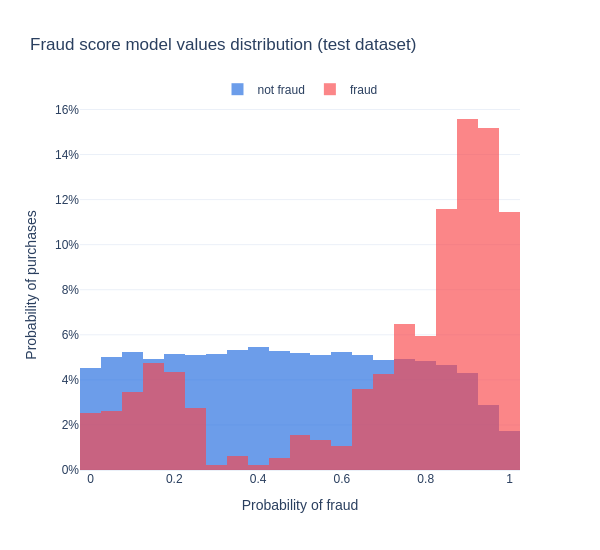

In [27]:
# Fraud score model values distribution
plot.overlaid_histograms(
    df=current_model_test_scores,
    numeric_feature='fraud_score_model',
    binary_feature='fraud',
    positive_label='fraud',
    negative_label='not fraud',
    title='Fraud score model values distribution (test dataset)',
    xaxis_title='Probability of fraud',
    yaxis_title='Probability of purchases',
)

### ROC AUC

In [31]:
fpr_current_model, tpr_current_model, thresholds_current_model = roc_curve(
    current_model_test_scores['fraud'],
    current_model_test_scores['fraud_score_model']
)

auc_current_model = auc(fpr_current_model, tpr_current_model)

print("ROC AUC: ", auc_current_model.round(2))

ROC AUC:  0.73


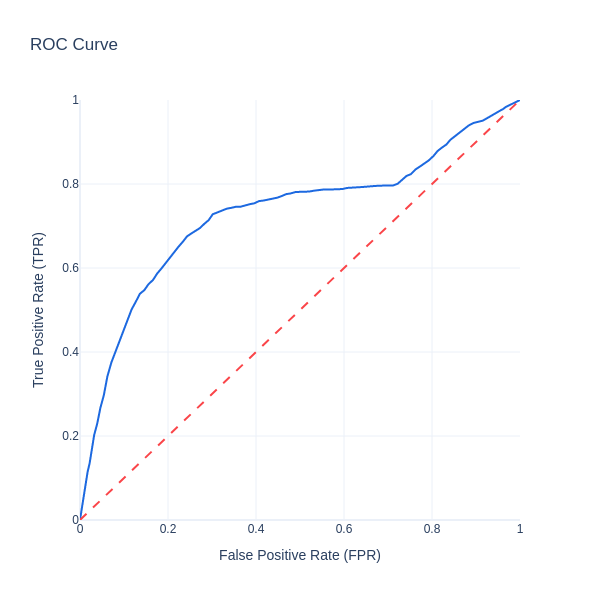

In [44]:
plot.roc_curve(fpr_current_model, tpr_current_model, thresholds_current_model)

## XGBoost

### Optuna tuning

In [9]:
def xgboost_objective(trial):
    # Defining the hyperparameters to be optimized
    params = {
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "enable_categorical": True,
        "tree_method": "auto",
        "device": "cpu",
        "importance_type": 'gain',
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_weight": trial.suggest_float("min_child_weight", 0.1, 10, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 0.9),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.7, 0.9),
        "gamma": trial.suggest_float("gamma", 1e-8, 5.0, log=True),
        "lambda": trial.suggest_float("lambda", 1e-8, 10.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 10.0, log=True),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 15.0, 30.0, log=True)
    }

    threshold = trial.suggest_float("threshold", 0.25, 0.85)

    # Set k-fold cross validation
    kf = StratifiedKFold(n_splits=5, shuffle=True)

    fold_profits = []

    # Iterate over each fold
    for train_index, valid_index in kf.split(X_train, y_train):
        X_train_fold = X_train.iloc[train_index]
        y_train_fold = y_train.iloc[train_index]
        X_valid_fold = X_train.iloc[valid_index]
        y_valid_fold = y_train.iloc[valid_index]

        # Create the model
        model_fold = xgb.XGBClassifier(**params)

        # Train the model
        model_fold.fit(X_train_fold, y_train_fold)

        # Predict the probabilities
        y_proba_fold = model_fold.predict_proba(X_valid_fold)[:, 1]

        # Calculate the profit of this fold
        fold_profit = model.profit_score(
            y_valid_fold.to_numpy(),
            y_proba_fold,
            X_valid_fold['purchase_value'].to_numpy(),
            threshold=threshold
        )

        fold_profits.append(fold_profit)

    return np.mean(fold_profits)


In [10]:
xgboost_study = optuna.create_study(study_name='xgboost', direction="maximize")
xgboost_study.optimize(xgboost_objective, n_trials=50, n_jobs=3, show_progress_bar=True)

xgboost_best_params = xgboost_study.best_params
xgboost_best_score = xgboost_study.best_value

[I 2025-04-15 17:13:31,566] A new study created in memory with name: xgboost


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-04-15 17:15:20,174] Trial 2 finished with value: 116197348.47000082 and parameters: {'learning_rate': 0.15059515982130758, 'max_depth': 4, 'min_child_weight': 1.8205108308825193, 'subsample': 0.546288033111592, 'colsample_bytree': 0.8647379669278181, 'gamma': 4.611524429049676e-06, 'lambda': 0.09907648851904302, 'alpha': 4.284789941020512, 'scale_pos_weight': 22.904724189124444, 'threshold': 0.6612762133976279}. Best is trial 1 with value: 341207296.70999926.
[I 2025-04-15 17:15:20,175] Trial 1 finished with value: 341207296.70999926 and parameters: {'learning_rate': 0.27861790239998074, 'max_depth': 5, 'min_child_weight': 0.19038915447855853, 'subsample': 0.638298674305567, 'colsample_bytree': 0.7171112139758741, 'gamma': 0.00038527000873552955, 'lambda': 0.30584478248172764, 'alpha': 0.016355749188809693, 'scale_pos_weight': 21.25606646282653, 'threshold': 0.691478751319889}. Best is trial 1 with value: 341207296.70999926.
[I 2025-04-15 17:15:41,501] Trial 0 finished with val

In [11]:
xgboost_best_params

{'learning_rate': 0.22974660576380537,
 'max_depth': 11,
 'min_child_weight': 0.2503581272819878,
 'subsample': 0.8668429627487773,
 'colsample_bytree': 0.8461820973073648,
 'gamma': 1.9633283753575396e-07,
 'lambda': 4.662731497559568e-08,
 'alpha': 0.0025667350798461775,
 'scale_pos_weight': 15.643309292522465,
 'threshold': 0.84942975510406}

### Model fit

In [12]:
# Create the model
xgb_threshold = xgboost_best_params.pop('threshold')
xgb_model = xgb.XGBClassifier(**xgboost_best_params, enable_categorical=True)

# Train the model
xgb_model.fit(X_train, y_train)


XGBClassifier(alpha=0.0025667350798461775, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8461820973073648, device=None,
              early_stopping_rounds=None, enable_categorical=True,
              eval_metric=None, feature_types=None,
              gamma=1.9633283753575396e-07, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              lambda=4.662731497559568e-08, learning_rate=0.22974660576380537,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=11, max_leaves=None,
              min_child_weight=0.2503581272819878, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, ...)

### Model calibration

In [14]:
# Calibrate probabilities
calibrated_xgb_model = CalibratedClassifierCV(xgb_model, method='isotonic', cv="prefit")
calibrated_xgb_model.fit(X_calib, y_calib[prm['models']['target'][0]])

def xgboost_calibration_objective(trial):
    # Defining the hyperparameters to be optimized
    threshold = trial.suggest_float("threshold", 0.25, 0.85)


    # Test the model
    calibration_profit = model.profit_score(
        y_calib[prm['models']['target'][0]].to_numpy(),
        calibrated_xgb_model.predict_proba(X_calib)[:, 1],
        X_calib['purchase_value'].to_numpy(),
        threshold=threshold
    )

    return calibration_profit

xgboost_calibration_study = optuna.create_study(study_name='xgboost_calibration', direction="maximize")
xgboost_calibration_study.optimize(xgboost_calibration_objective, n_trials=500, n_jobs=3, show_progress_bar=True)

xgboost_calibration_best_params = xgboost_calibration_study.best_params
xgboost_calibration_best_score = xgboost_calibration_study.best_value

/home/henrique/Projetos/e-commerce-fraud-detection/.venv/lib/python3.12/site-packages/sklearn/calibration.py:333: UserWarning:

The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.

[I 2025-04-15 17:44:00,664] A new study created in memory with name: xgboost_calibration


  0%|          | 0/500 [00:00<?, ?it/s]

[I 2025-04-15 17:44:00,872] Trial 0 finished with value: 6809.912000000003 and parameters: {'threshold': 0.43207474894898845}. Best is trial 0 with value: 6809.912000000003.
[I 2025-04-15 17:44:00,957] Trial 1 finished with value: 5645.432000000004 and parameters: {'threshold': 0.7752594813984824}. Best is trial 0 with value: 6809.912000000003.
[I 2025-04-15 17:44:00,968] Trial 2 finished with value: 8644.214000000004 and parameters: {'threshold': 0.2746507289217806}. Best is trial 2 with value: 8644.214000000004.
[I 2025-04-15 17:44:01,035] Trial 3 finished with value: 6809.912000000003 and parameters: {'threshold': 0.5147795121025724}. Best is trial 2 with value: 8644.214000000004.
[I 2025-04-15 17:44:01,107] Trial 4 finished with value: 8644.214000000004 and parameters: {'threshold': 0.26331987441964916}. Best is trial 2 with value: 8644.214000000004.
[I 2025-04-15 17:44:01,165] Trial 5 finished with value: 6809.912000000003 and parameters: {'threshold': 0.45463802740494696}. Best i

In [19]:
# Get calibrated threshold
xgboost_calibration_threshold = xgboost_calibration_best_params.get("threshold", xgb_threshold)

# Get calibrated probabilities
y_test_model_proba = calibrated_xgb_model.predict_proba(X_test)[:, 1]

### Model test

In [20]:
# Test the model
test_profit = model.profit_score(
    y_test[prm['models']['target'][0]].to_numpy(),
    y_test_model_proba,
    X_test['purchase_value'].to_numpy(),
    threshold=xgboost_calibration_threshold
)

print(f"XGBoost model generates a profit of {test_profit:,.2f} USD for test dataset")

XGBoost model generates a profit of 25,448.12 USD for test dataset


### Model performance

In [21]:
xgb_test_data = pd.DataFrame({
    "y_test": y_test[prm['models']['target'][0]].to_numpy(),
    "y_test_model": np.where(y_test_model_proba > xgboost_calibration_threshold, 1, 0),
    "y_test_model_proba": y_test_model_proba,
    "purchase_value": X_test['purchase_value'].to_numpy(),
})

xgb_test_data

,y_test,y_test_model,y_test_model_proba,purchase_value
0,0,0,0.011111,8.78
1,0,0,0.055814,139.35
2,0,0,0.127027,27.35
3,0,0,0.037080,12.48
4,0,0,0.089059,17.74
...,...,...,...,...
29995,0,0,0.023224,30.26
29996,0,0,0.037080,5.77
29997,0,0,0.053391,4.45
29998,0,0,0.037080,47.18


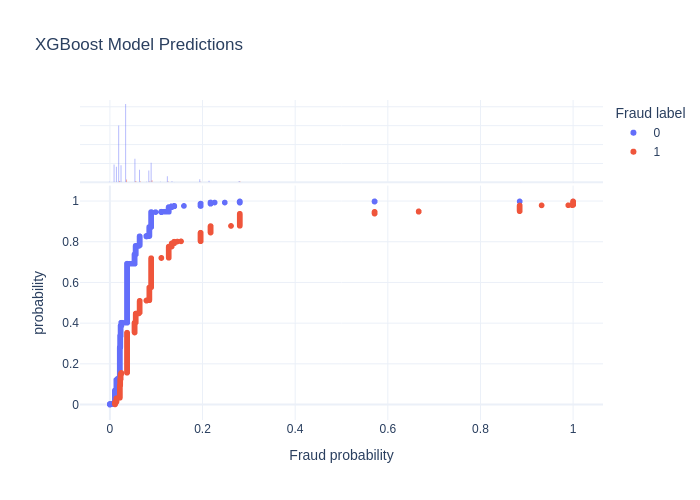

In [24]:
# Plot test data and model predictions
fig = px.ecdf(
    xgb_test_data,
    x="y_test_model_proba",
    color="y_test",
    markers=True,
    lines=False,
    marginal="histogram",
    labels={
        "y_test_model_proba": "Fraud probability",
        "y_test": "Fraud label",
        "count": "Count"
    },
    title="XGBoost Model Predictions",
)

fig.show()

In [25]:
# Make a confusion matrix
confusion_matrix = pd.crosstab(
    xgb_test_data["y_test"],
    xgb_test_data["y_test_model"],
    rownames=["Actual"],
    colnames=["Predicted"],
)
confusion_matrix

Predicted,0,1
Actual,,
0,28348,152
1,1319,181
